# Traffic site boosting with machine learning.


## Packages and styles

In [40]:
#%reset

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
from scipy.stats import skew
from scipy.stats.mstats import winsorize
from sklearn.metrics import f1_score, precision_recall_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

## Data validation
To know the measures of spread and other descriptive statics of the data is helpful on deciding on how to make it proper and ready to use in machine learning modeling.

In [42]:
df_m = pd.read_csv("recipe_site_traffic_2212.csv")
df = df_m.copy()

### Descriptive statistics

In [43]:
display('head\n',df.head())
print('\ninfo')
df.info()
print('\ndescribe\n',df.describe())
print('\nunique values\n',df.nunique())
print('\ncolumn names\n',df.columns)

'head\n'

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN



info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB

describe
            recipe     calories  carbohydrate       sugar     protein
count  947.000000   895.000000    895.000000  895.000000  895.000000
mean   474.000000   435.939196     35.069676    9.046547   24.149296
std    273.519652   453.020997     43.949032   14.679176   36.369739
min      1.000000     0.140000      0.030000    0.010000    0.000000
25%    237.500000   110.430000      8.375

### Missing values and data types
There are around 5.4% of data missing from the columns "calories", "carbohydrate", "sugar", and "protein", and 39.3% of data missing from the "high_traffic" column. The missing values were dropped* from the dataset.

The values from "servings" like "4 as a snack" were replaced by "4". Also, the columns "high_traffic", "recipe", and "servings" had have their type adjusted to integer, string, and integer, respectivelly.

**Decided on dropping because: 1. losing around 52 rows (5.4% of 947) is unlikely to significantly affect model generalizability; and 2. Imputing skewed data (e.g., mean/median) would introduce bias, as these features have extreme outliers (e.g., max calories = 3,633); and 3. These columns are not missing at random—recipes with missing nutritional data were disproportionately from categories like "Pork" and "Lunch/Snacks," which showed no significant correlation with high_traffic in EDA.*

In [44]:
for column in df.columns:
    if column == 'recipe':
        pass
    elif df[column].dtype.name == 'float64':
        pass
    else:
        print(column+":", df[column].unique())

category: ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
servings: ['6' '4' '1' '2' '4 as a snack' '6 as a snack']
high_traffic: ['High' nan]


In [45]:
print("How much data is missing?\nIn percentage\n")
print(df.isna().mean()*100)

display(df[df['calories'].isnull() == True])

missing_categories = df[df['calories'].isnull()]['category'].value_counts()
print(missing_categories)

missing_servings = df[df['calories'].isnull()]['servings'].value_counts()
print(missing_servings)

missing_traffic = df[df['calories'].isnull()]['high_traffic'].value_counts()
print(missing_traffic)

missing_categories_by_traffic = df[df['calories'].isnull()][df['high_traffic'] == '1']['category'].value_counts()
print(missing_categories_by_traffic)

How much data is missing?
In percentage

recipe           0.000000
calories         5.491024
carbohydrate     5.491024
sugar            5.491024
protein          5.491024
category         0.000000
servings         0.000000
high_traffic    39.387540
dtype: float64


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,NaN
48,49,NaN,NaN,NaN,NaN,Chicken Breast,4,NaN
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
116,117,NaN,NaN,NaN,NaN,Chicken Breast,6,High
121,122,NaN,NaN,NaN,NaN,Dessert,2,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,150,NaN,NaN,NaN,NaN,Potato,2,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High


Pork              11
Lunch/Snacks       7
Dessert            6
Meat               5
Potato             5
Chicken            5
Vegetable          5
Chicken Breast     4
One Dish Meal      4
Name: category, dtype: int64
4    24
6    13
2     9
1     6
Name: servings, dtype: int64
High    39
Name: high_traffic, dtype: int64
Series([], Name: category, dtype: int64)


In [46]:
df['servings'][df['servings']=='4 as a snack'] = '4'
df['servings'][df['servings']=='6 as a snack'] = '6'

df['high_traffic'][df['high_traffic']=='High'] = '1'
df['high_traffic'] = df['high_traffic'].fillna('0')
df['high_traffic'] = df['high_traffic'].astype('int')
df['recipe'] = df['recipe'].astype('str', errors='raise')
df['servings'] = df['servings'].astype('int')
df = df.dropna()

### Handling outliers and assimetry
Outliers and positive skewness were identified — visually and numerically — and treated with transformations and capping techniques. Some of the models, that will be used to approach the problem, are sensitive to outliers and assimetry in data, hence the need to handle these two characteristics beforehand.

#### Searching for outliers

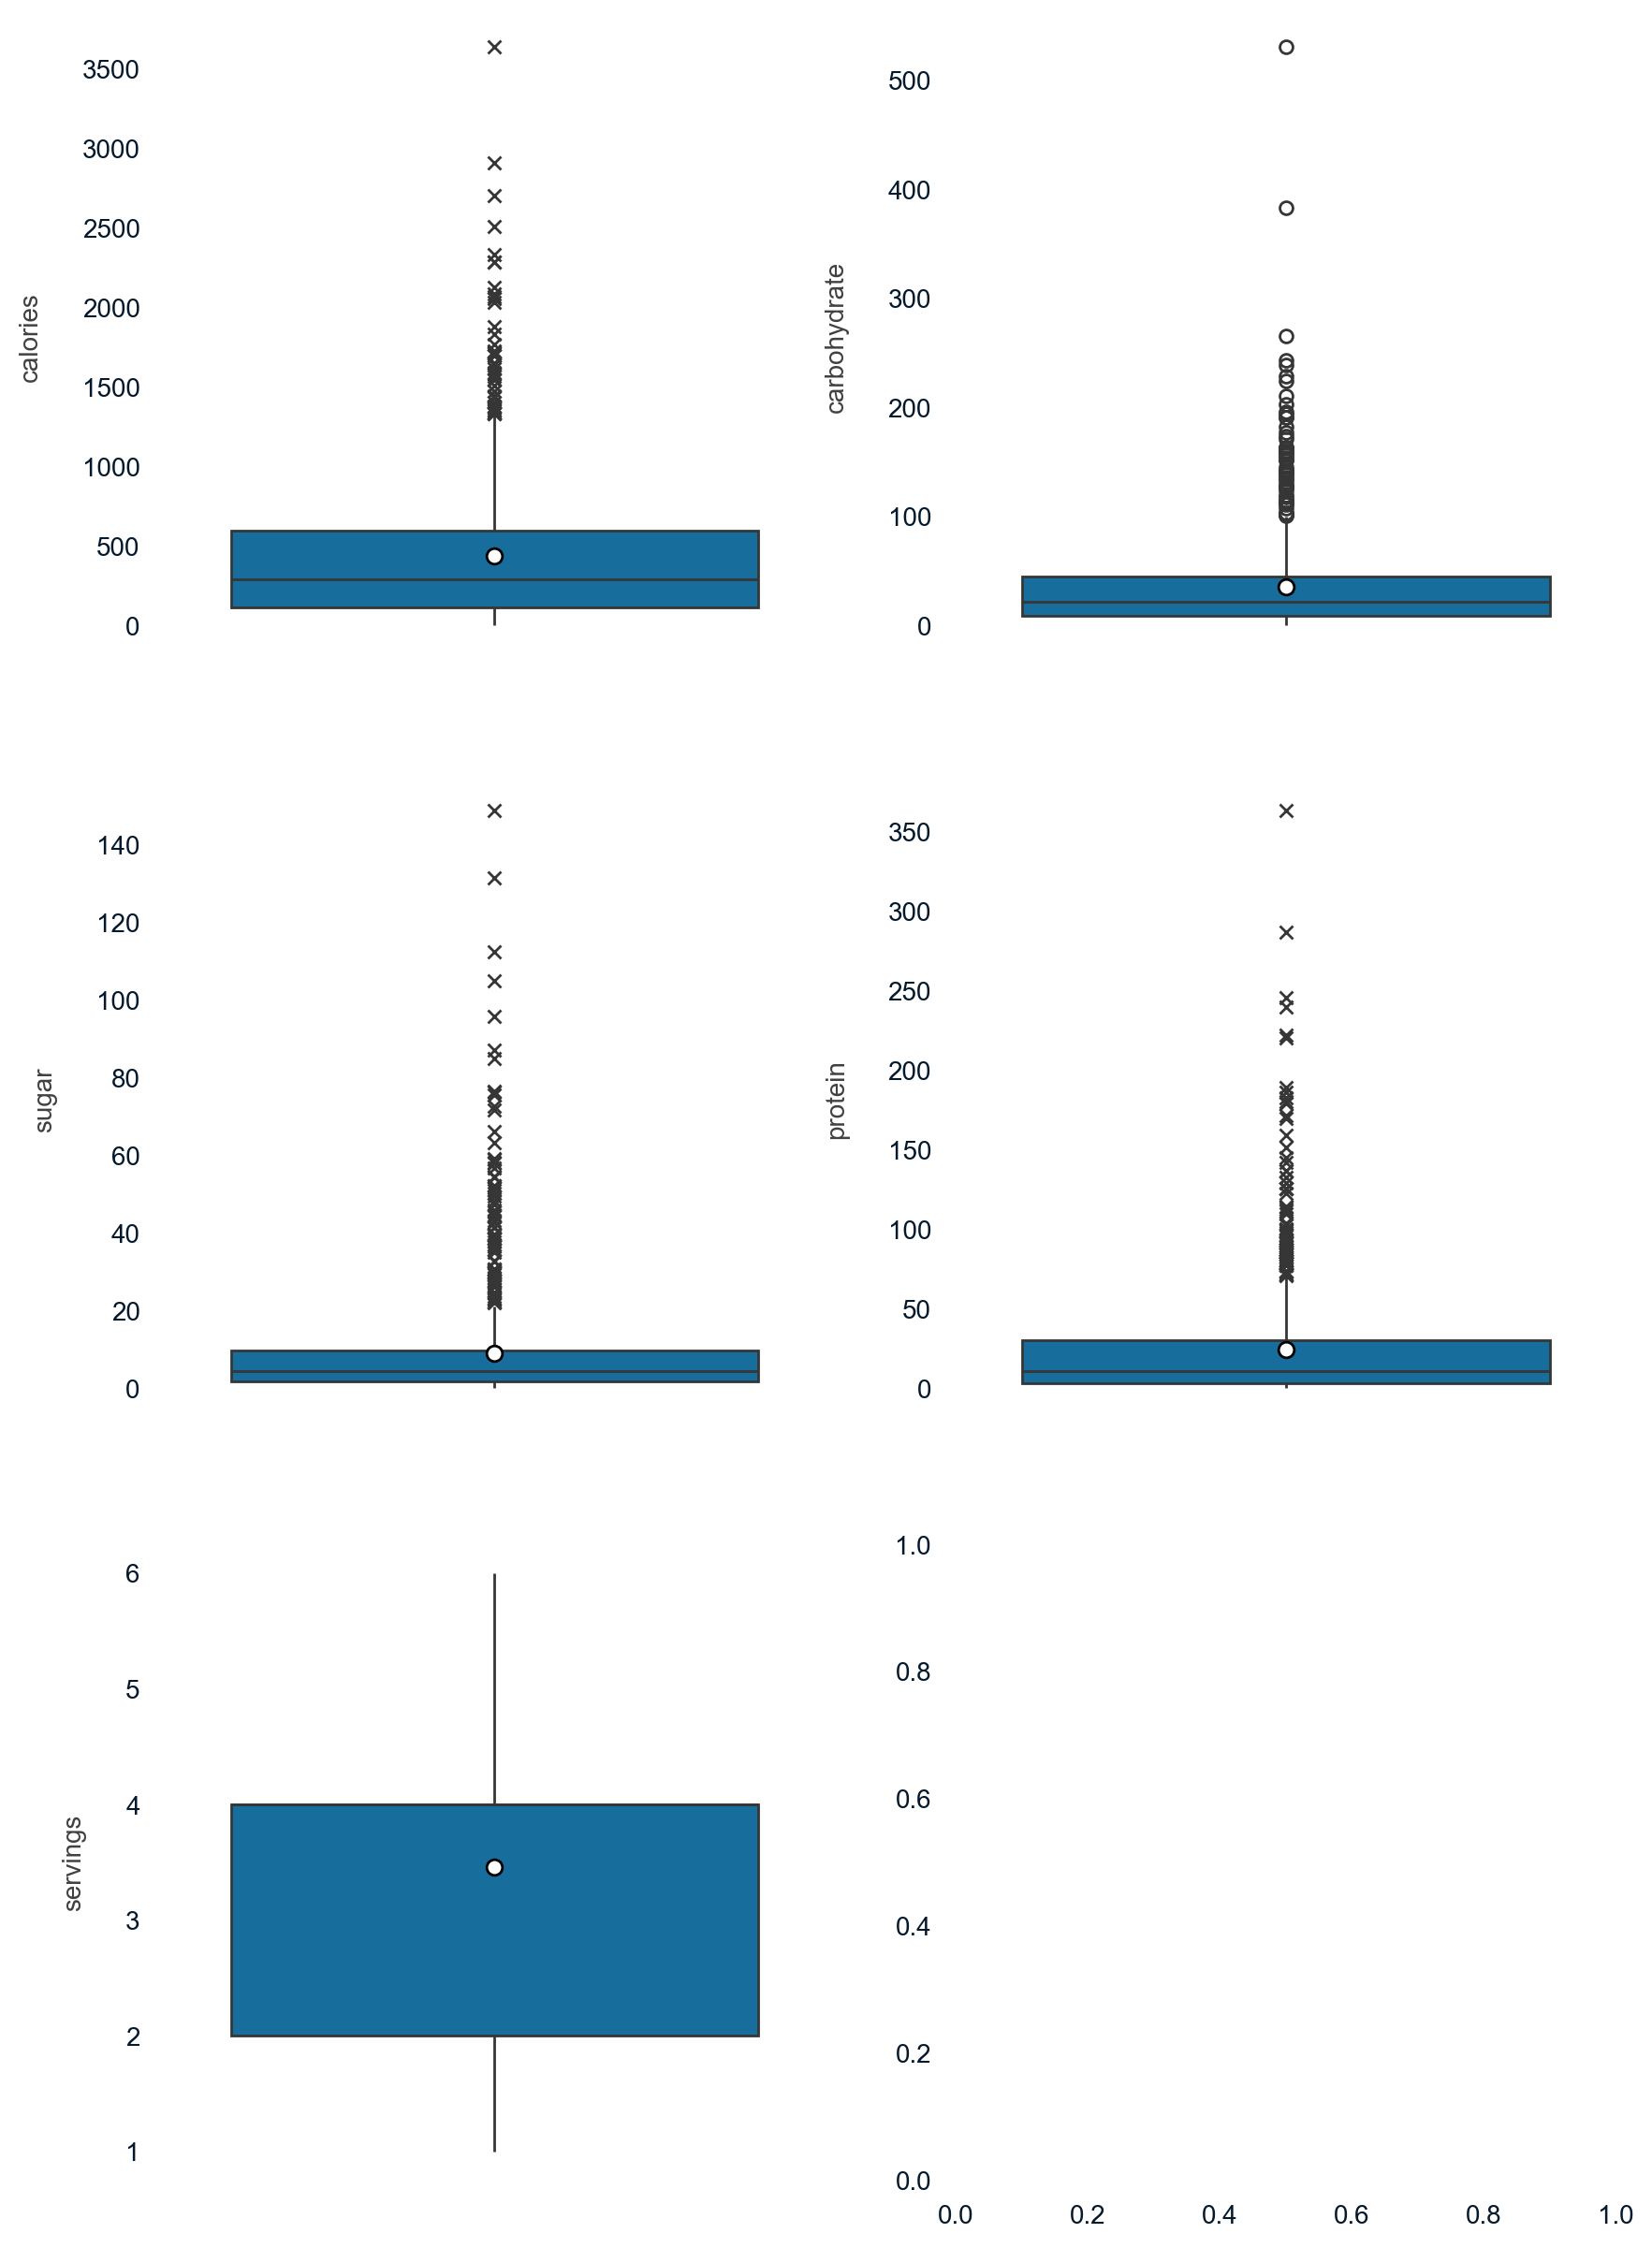

In [47]:
sns.set_theme(style="white")
sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

fig, axs = plt.subplots(figsize=(10, 15), dpi=100, ncols=2, nrows=3)

boxplot = sns.boxplot(
    y = 'calories',
    data = df,
    showmeans=True,
    flierprops={"marker": "x"},
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    notch=False,
    showcaps=False,
    ax=axs[0, 0]
)
boxplot = sns.boxplot(
    y = 'carbohydrate',
    data = df,
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    notch=False,
    showcaps=False,
    ax=axs[0, 1]
)
boxplot = sns.boxplot(
    y = 'sugar',
    data = df,
    showmeans=True,
    flierprops={"marker": "x"},
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    notch=False,
    showcaps=False,
    ax=axs[1, 0]
)
boxplot = sns.boxplot(
    y = 'protein',
    data = df,
    showmeans=True,
    flierprops={"marker": "x"},
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    notch=False,
    showcaps=False,
    ax=axs[1, 1]
)
boxplot = sns.boxplot(
    y = 'servings',
    data = df,
    showmeans=True,
    flierprops={"marker": "x"},
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    notch=False,
    showcaps=False,
    ax=axs[2, 0]
)

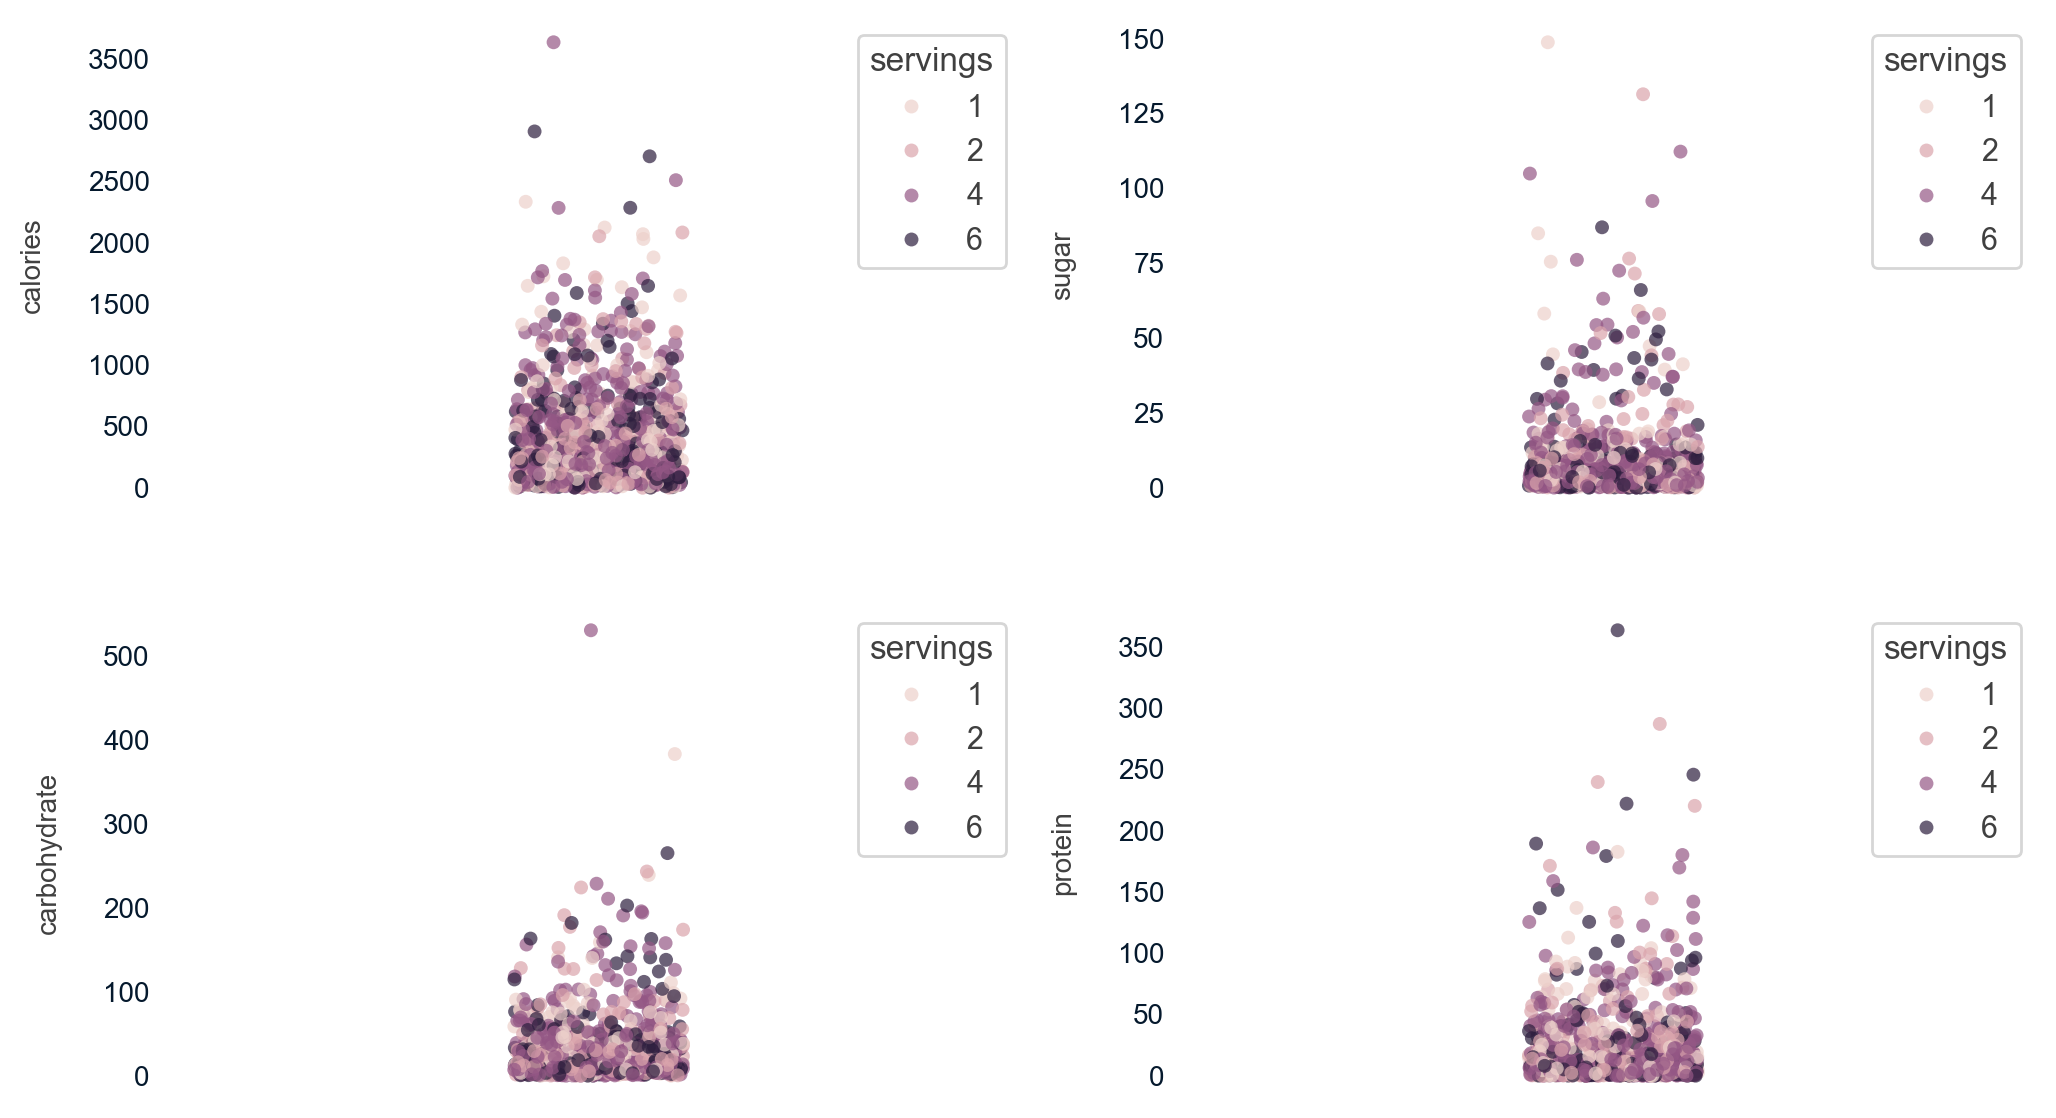

In [48]:
sns.set_theme(style="white")
plt.style.use('my_style.mplstyle')

fig, axs = plt.subplots(figsize=(12, 7), dpi=100, ncols=2, nrows=2)

boxplot = sns.stripplot(
    y = 'calories',
    data = df,
    jitter=True,
    alpha=0.7,
    hue='servings',
    ax=axs[0, 0]
)
boxplot = sns.stripplot(
    y = 'carbohydrate',
    data = df,
    jitter=True,
    alpha=0.7,
    hue='servings',
    ax=axs[1, 0]
)
boxplot = sns.stripplot(
    y = 'sugar',
    data = df,
    jitter=True,
    alpha=0.7,
    hue='servings',
    ax=axs[0, 1]
)
boxplot = sns.stripplot(
    y = 'protein',
    data = df,
    jitter=True,
    alpha=0.7,
    hue='servings',
    ax=axs[1, 1]
)

#### Assimetry
Numeric fields were checked for assimetry and the results showed positive skewness in four of the five fields: calories (2.03), carbohydrate (3.75), sugar (4.21), and protein (3.50).

In [49]:
print(df[['calories', 'sugar', 'carbohydrate', 'protein', 'servings']].describe(percentiles=[0.8, 0.9, 0.95]))

skewness = df[['calories', 'carbohydrate', 'sugar', 'protein', 'servings']].apply(skew)
print("Skewness:\n", skewness)

          calories       sugar  carbohydrate     protein    servings
count   895.000000  895.000000    895.000000  895.000000  895.000000
mean    435.939196    9.046547     35.069676   24.149296    3.458101
std     453.020997   14.679176     43.949032   36.369739    1.735979
min       0.140000    0.010000      0.030000    0.000000    1.000000
50%     288.550000    4.550000     21.480000   10.800000    4.000000
80%     709.366000   11.708000     51.676000   37.318000    6.000000
90%    1045.234000   18.838000     81.244000   64.066000    6.000000
95%    1331.998000   37.940000    115.715000   88.450000    6.000000
max    3633.160000  148.750000    530.420000  363.360000    6.000000
Skewness:
 calories        2.032737
carbohydrate    3.750681
sugar           4.216271
protein         3.503568
servings        0.010128
dtype: float64


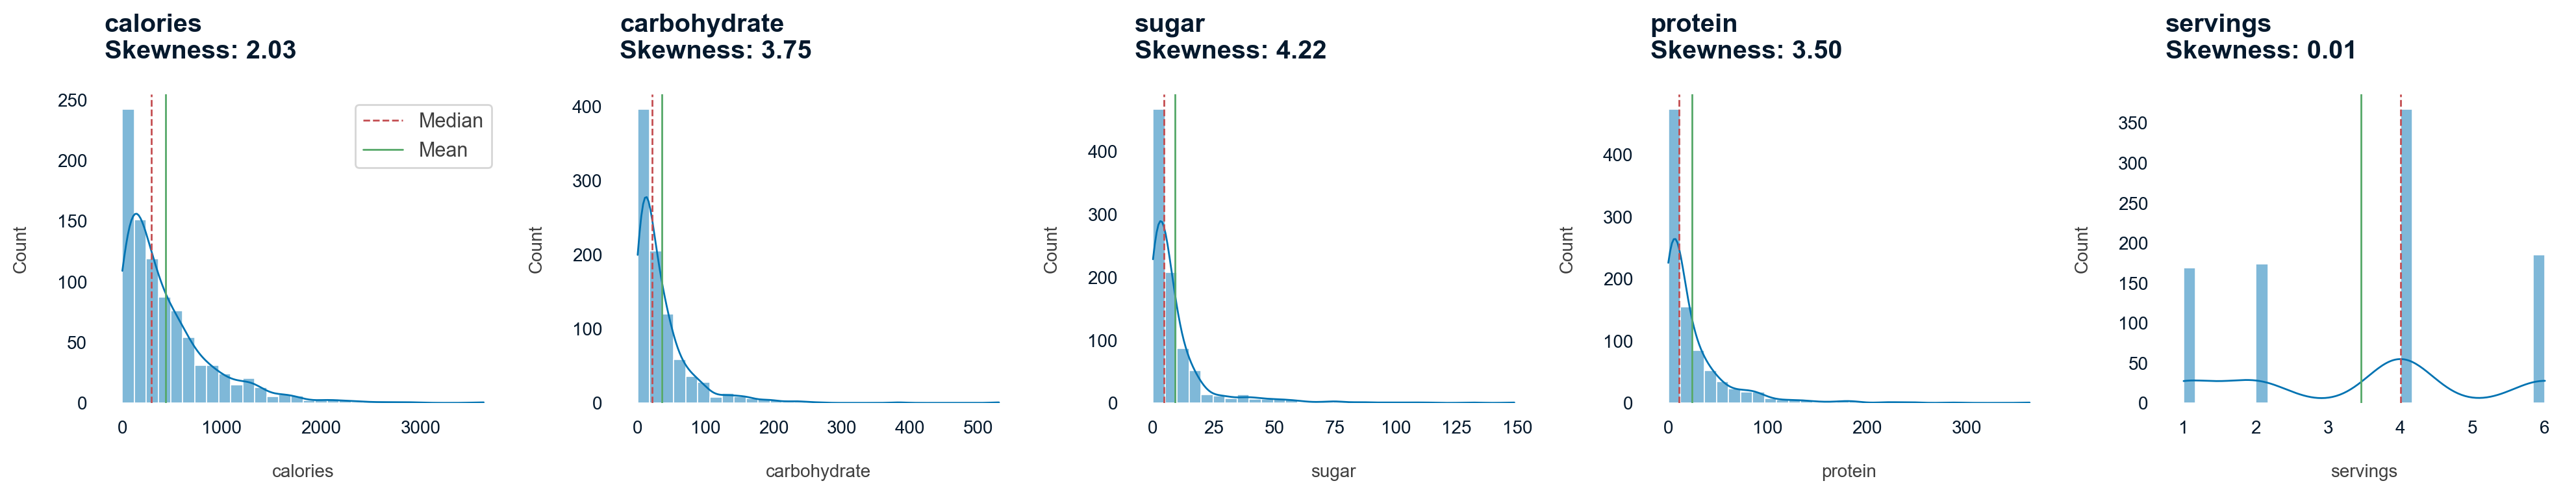

In [50]:
sns.set_theme(style="white")
sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

# Create a single figure with 5 subplots
plt.figure(figsize=(20, 4))  # Width adjusted for 5 plots

# Plot each feature in a subplot
for i, col in enumerate(['calories', 'carbohydrate', 'sugar', 'protein', 'servings'], 1):
    plt.subplot(1, 5, i)  # 1 row, 5 columns, current subplot position
    sns.histplot(df[col], kde=True, bins=30)
    plt.axvline(df[col].median(), color='r', linestyle='--', label='Median')
    plt.axvline(df[col].mean(), color='g', linestyle='-', label='Mean')
    plt.title(f'{col}\nSkewness: {skewness[col]:.2f}')
    plt.xlabel(col)
    if i == 1:  # Add legend only once to avoid repetition
        plt.legend()

plt.tight_layout()  # Prevent overlapping labels
plt.show()

In [55]:
df_clean_data = df.copy()

#### Transforming
To neutralize data assimetry the following techniques were used: **Logarithmic transformations** (ideal for highly skewed, non-zero data), and **Square root** (a safer choice for features with zeros or moderate skewness).

To handle outliers: **IQR capping**.

In [56]:
# Apply log(x + 1) to handle zeros
for col in ['calories', 'sugar', 'carbohydrate']:
    df_clean_data[f'{col}'] = np.log1p(df_clean_data[col])
    
    # Verify skewness reduction
    print(f"{col} post-log skewness: {skew(df_clean_data[f'{col}']):.2f}")

df_clean_data['protein'] = np.sqrt(df_clean_data['protein'])
print(f"Protein post-sqrt skewness: {skew(df_clean_data['protein']):.2f}")

def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap only highs (preserve lows)
    df[column] = df[column].clip(upper=upper_bound)
    return df

# Apply to transformed columns
for col in ['calories', 'sugar', 'carbohydrate', 'protein']:
    df_clean_data = cap_outliers_iqr(df_clean_data, col)

calories post-log skewness: -0.95
sugar post-log skewness: 0.50
carbohydrate post-log skewness: -0.28
Protein post-sqrt skewness: 1.26


In [57]:
print(df_clean_data[['calories', 'sugar', 'carbohydrate', 'protein', 'servings']].describe(percentiles=[0.8, 0.9, 0.95]))

skewness = df_clean_data[['calories', 'carbohydrate', 'sugar', 'protein', 'servings']].apply(skew)
print("Skewness:\n", skewness)

         calories       sugar  carbohydrate     protein    servings
count  895.000000  895.000000    895.000000  895.000000  895.000000
mean     5.466465    1.750533      3.006051    3.892513    3.458101
std      1.307362    0.983783      1.146149    2.725742    1.735979
min      0.131028    0.009950      0.029559    0.000000    1.000000
50%      5.668328    1.713798      3.112626    3.286335    4.000000
80%      6.565778    2.542231      3.964160    6.108843    6.000000
90%      6.952952    2.987599      4.409682    8.004121    6.000000
95%      7.195184    3.661997      4.759639    9.404766    6.000000
max      8.198133    4.464554      6.212649   11.057307    6.000000
Skewness:
 calories       -0.945411
carbohydrate   -0.283800
sugar           0.463342
protein         0.847668
servings        0.010128
dtype: float64


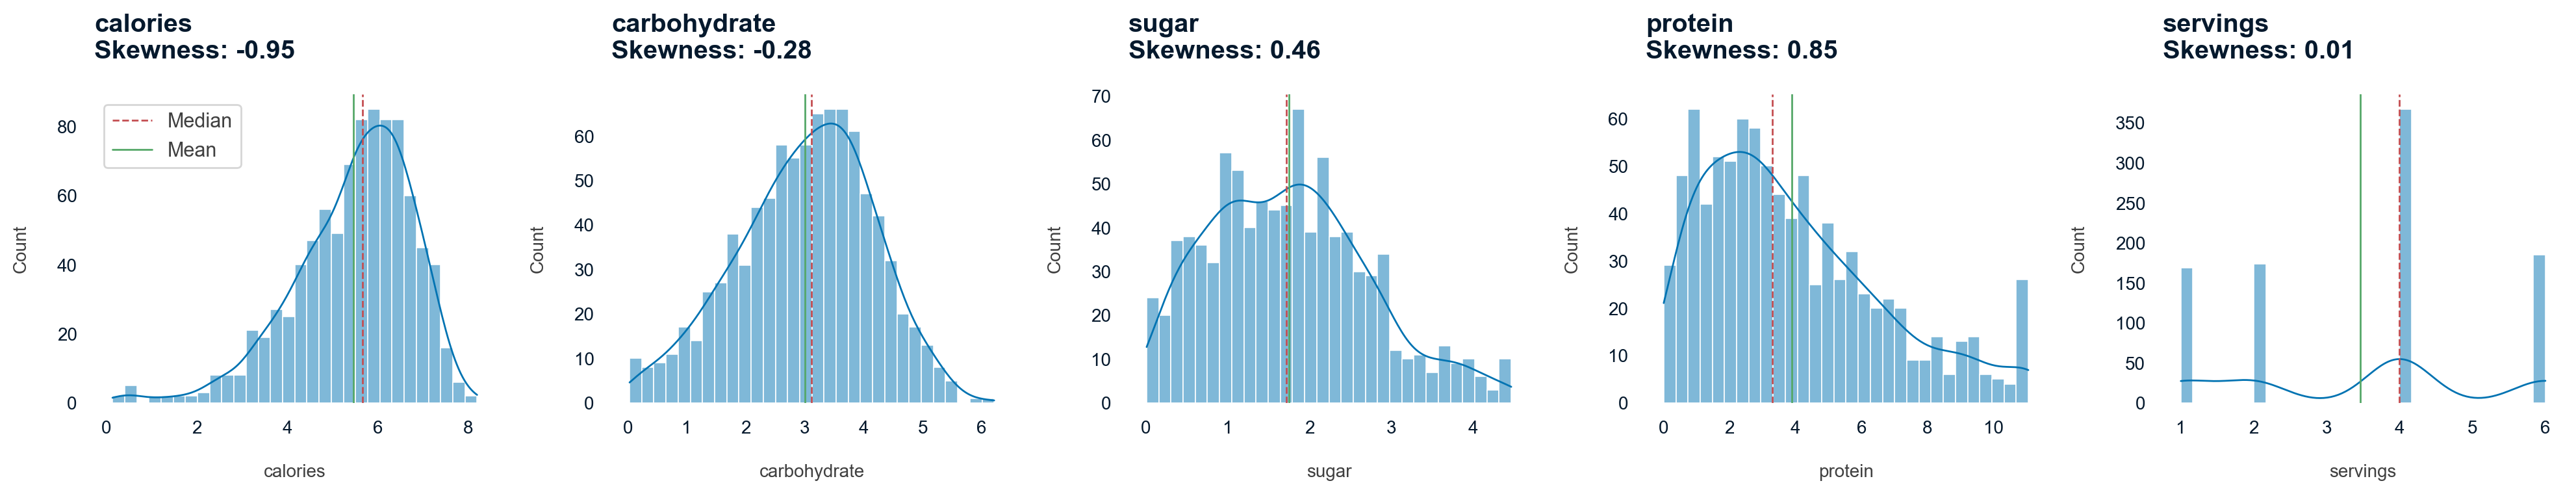

In [58]:
sns.set_theme(style="white")
sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

plt.figure(figsize=(20, 4))

for i, col in enumerate(['calories', 'carbohydrate', 'sugar', 'protein', 'servings'], 1):
    plt.subplot(1, 5, i)  # 1 row, 5 columns, current subplot position
    sns.histplot(df_clean_data[col], kde=True, bins=30)
    plt.axvline(df_clean_data[col].median(), color='r', linestyle='--', label='Median')
    plt.axvline(df_clean_data[col].mean(), color='g', linestyle='-', label='Mean')
    plt.title(f'{col}\nSkewness: {skewness[col]:.2f}')
    plt.xlabel(col)
    if i == 1:  # Add legend only once to avoid repetition
        plt.legend()

plt.tight_layout()
plt.show()

### Feature engineering
Some fields and values were identified to be linked to more popular recipes than the others, hence they may be used in the models as engineered features. The top values from the "categories" field, for instance, were: "Vegetable", "Potato", "Pork", "Meat", "Lunch/Snacks", and "One Dish Meal." Some interactions also have been noticed, for example: the recipes with chicken breast are highly protein and had large number of high traffic at the website. These types of interactions were created as artificial features, and passed by to the models.

On the modeling phase, some features were disregarded due and the dataframe pruned due to non predictive importance been observed.

#### Visualizing patterns

In [59]:
print(df.groupby('category').count().sort_values(by='high_traffic', ascending=False)['high_traffic'])

category
Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: high_traffic, dtype: int64


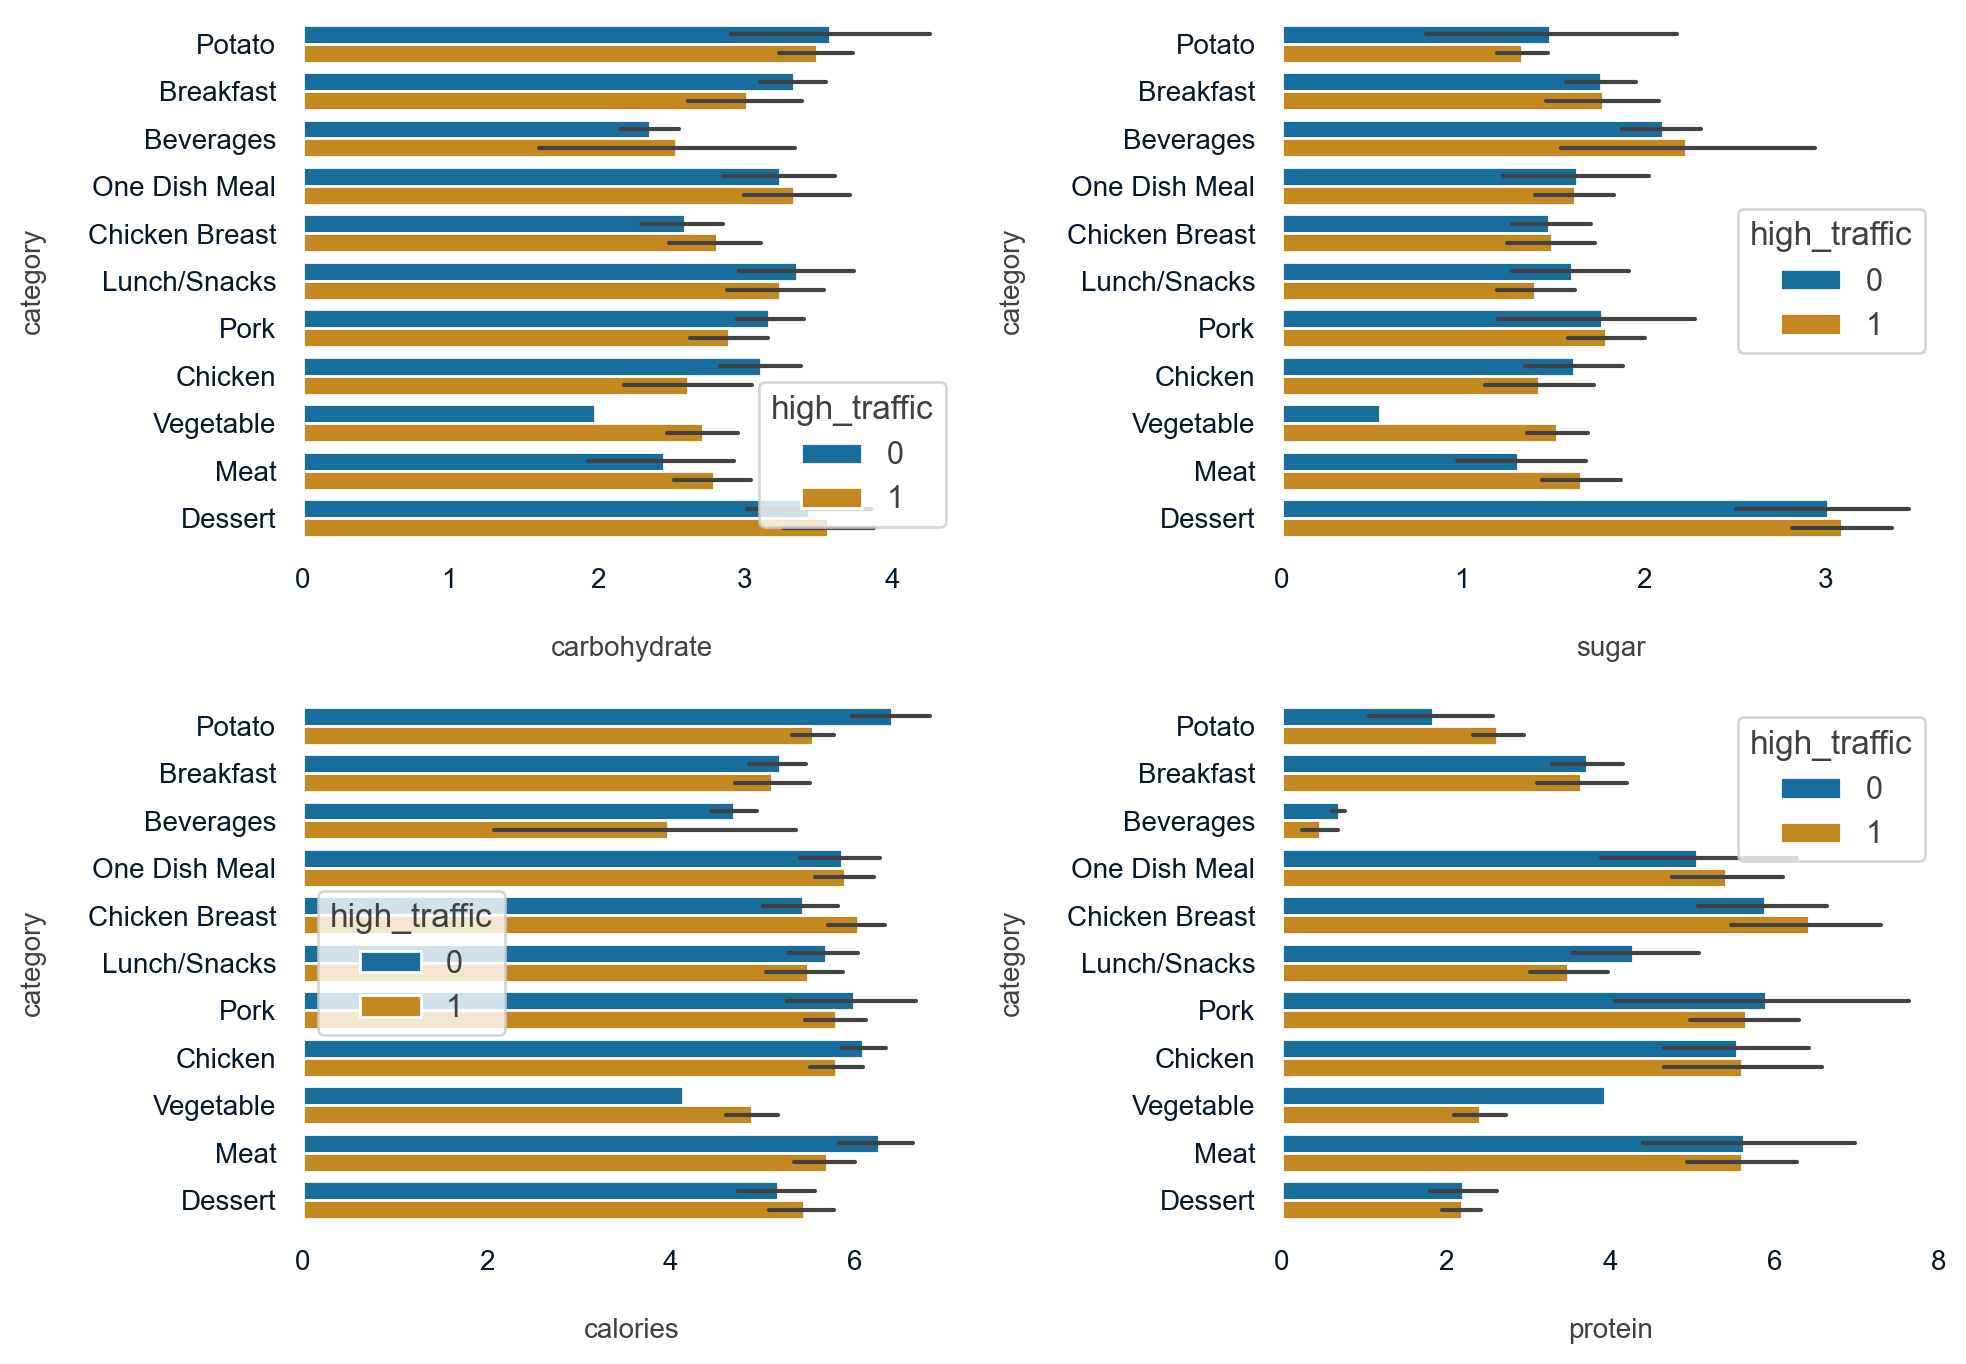

In [79]:
sns.set_theme(style="white")
sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

figs, axs = plt.subplots(figsize=(10, 7), dpi=100, ncols=2, nrows=2)

boxplot = sns.barplot(
    x = 'carbohydrate',
    y = 'category',
    hue = 'high_traffic',
    data = df_clean_data,
    #showmeans=True,  # Optional: show mean as a marker
    #flierprops={"marker": "x"},
    #meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    #notch=False, showcaps=False
    ax=axs[0, 0]
)

boxplot = sns.barplot(
    x = 'sugar',
    y = 'category',
    hue = 'high_traffic',
    data = df_clean_data,
    #showmeans=True,  # Optional: show mean as a marker
    #flierprops={"marker": "x"},
    #meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    #notch=False, showcaps=False
    ax=axs[0, 1]
)

boxplot = sns.barplot(
    x = 'protein',
    y = 'category',
    hue = 'high_traffic',
    data = df_clean_data,
    #showmeans=True,  # Optional: show mean as a marker
    #flierprops={"marker": "x"},
    #meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    #notch=False, showcaps=False
    ax=axs[1, 1]
)

boxplot = sns.barplot(
    x = 'calories',
    y = 'category',
    hue = 'high_traffic',
    data = df_clean_data,
    #showmeans=True,  # Optional: show mean as a marker
    #flierprops={"marker": "x"},
    #meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    #notch=False, showcaps=False
    ax=axs[1, 0]
)

plt.tight_layout()
plt.show()

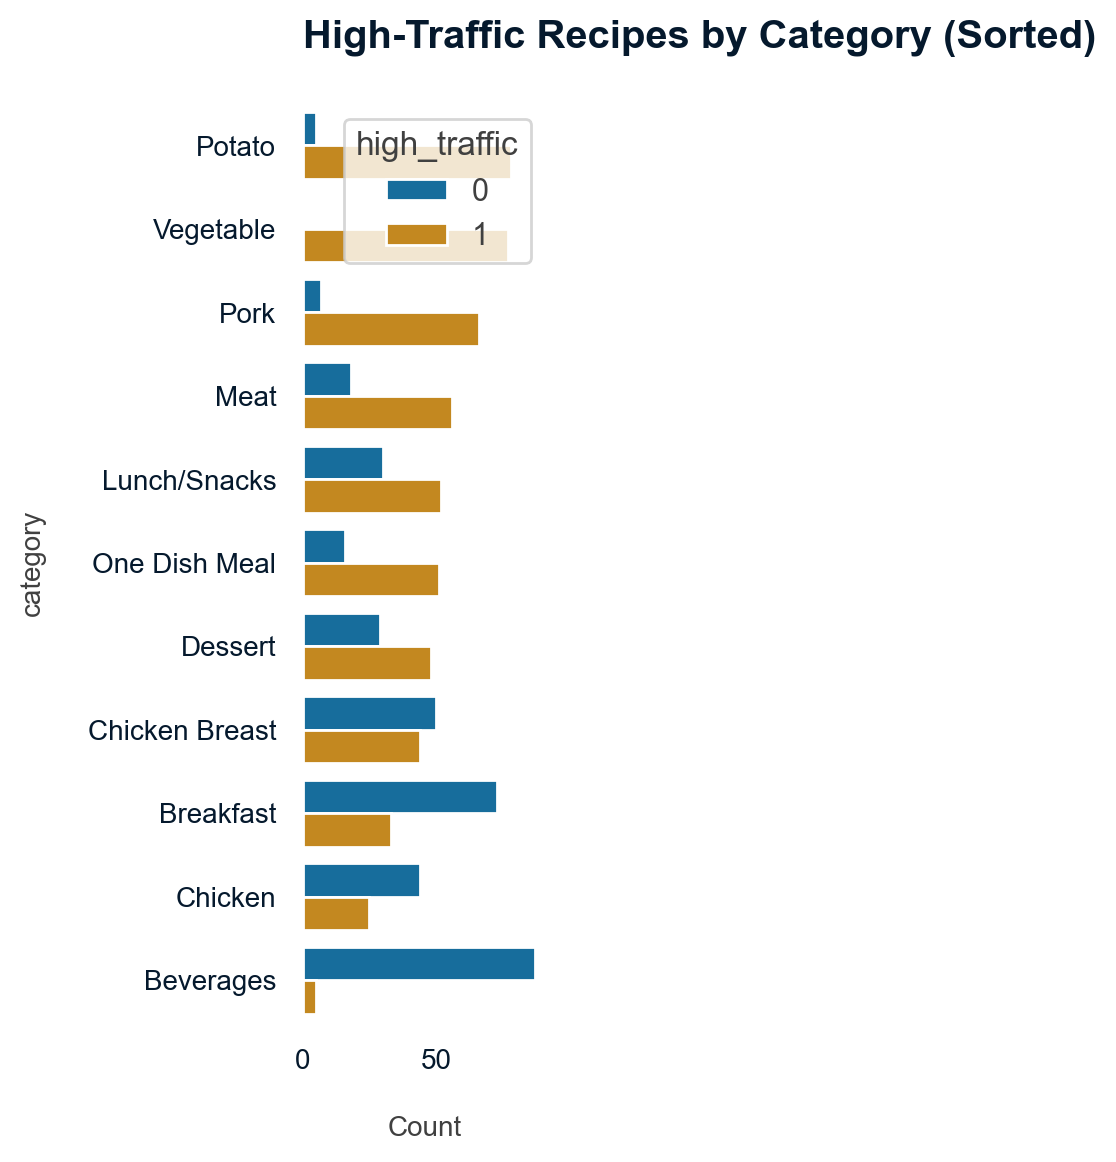

In [81]:
# Calculate counts for high-traffic recipes per category
high_traffic_counts = df_clean_data[df_clean_data['high_traffic'] == 1]['category'].value_counts().sort_values(ascending=False)

# Get ordered list of categories (sorted by high-traffic count)
category_order = high_traffic_counts.index.tolist()

sns.set_theme(style="white")
sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

# Plot with ordered categories
plt.figure(figsize=(6, 6))
cou = sns.countplot(
    data=df_clean_data,
    y="category",
    hue="high_traffic",
    order=category_order,
)
cou.set_title('High-Traffic Recipes by Category (Sorted)')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

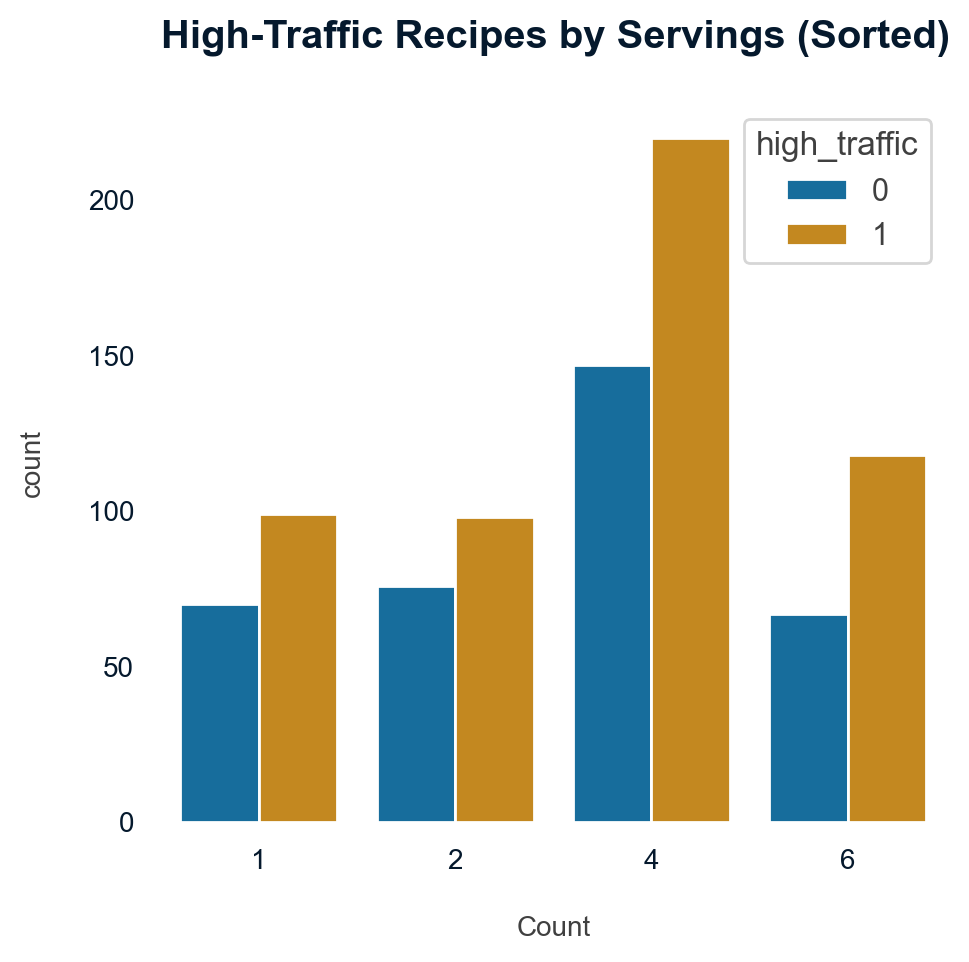

In [84]:
# Calculate counts for high-traffic recipes per category
high_traffic_counts = df_clean_data[df_clean_data['high_traffic'] == 1]['servings'].value_counts().sort_values(ascending=False)

# Get ordered list of categories (sorted by high-traffic count)
servings_order = high_traffic_counts.index.tolist()

sns.set_theme(style="white")
sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

# Plot with ordered categories
plt.figure(figsize=(5, 5))
cou = sns.countplot(
    data=df_clean_data,
    x="servings",
    hue="high_traffic",
)
cou.set_title('High-Traffic Recipes by Servings (Sorted)')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

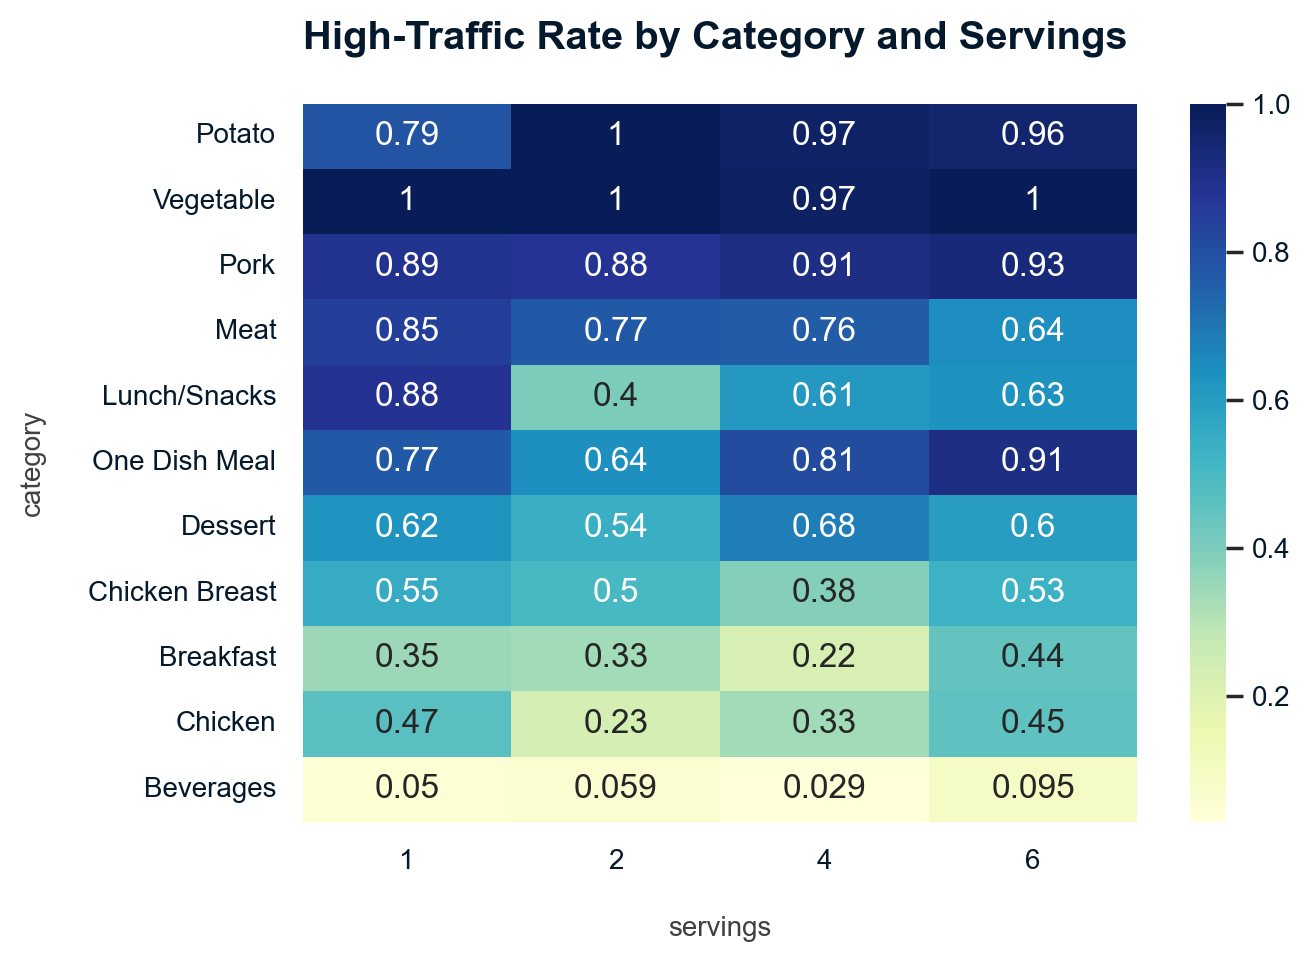

In [90]:
# Create a pivot table
heatmap_data = df_clean_data.pivot_table(
    index='category',
    columns='servings',
    values='high_traffic',
    aggfunc='mean'
)

# Sort categories by high-traffic frequency
heatmap_data = heatmap_data.loc[category_order]

sns.set_theme(style="white")
sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

# Plot
plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('High-Traffic Rate by Category and Servings')
plt.tight_layout()
plt.show()

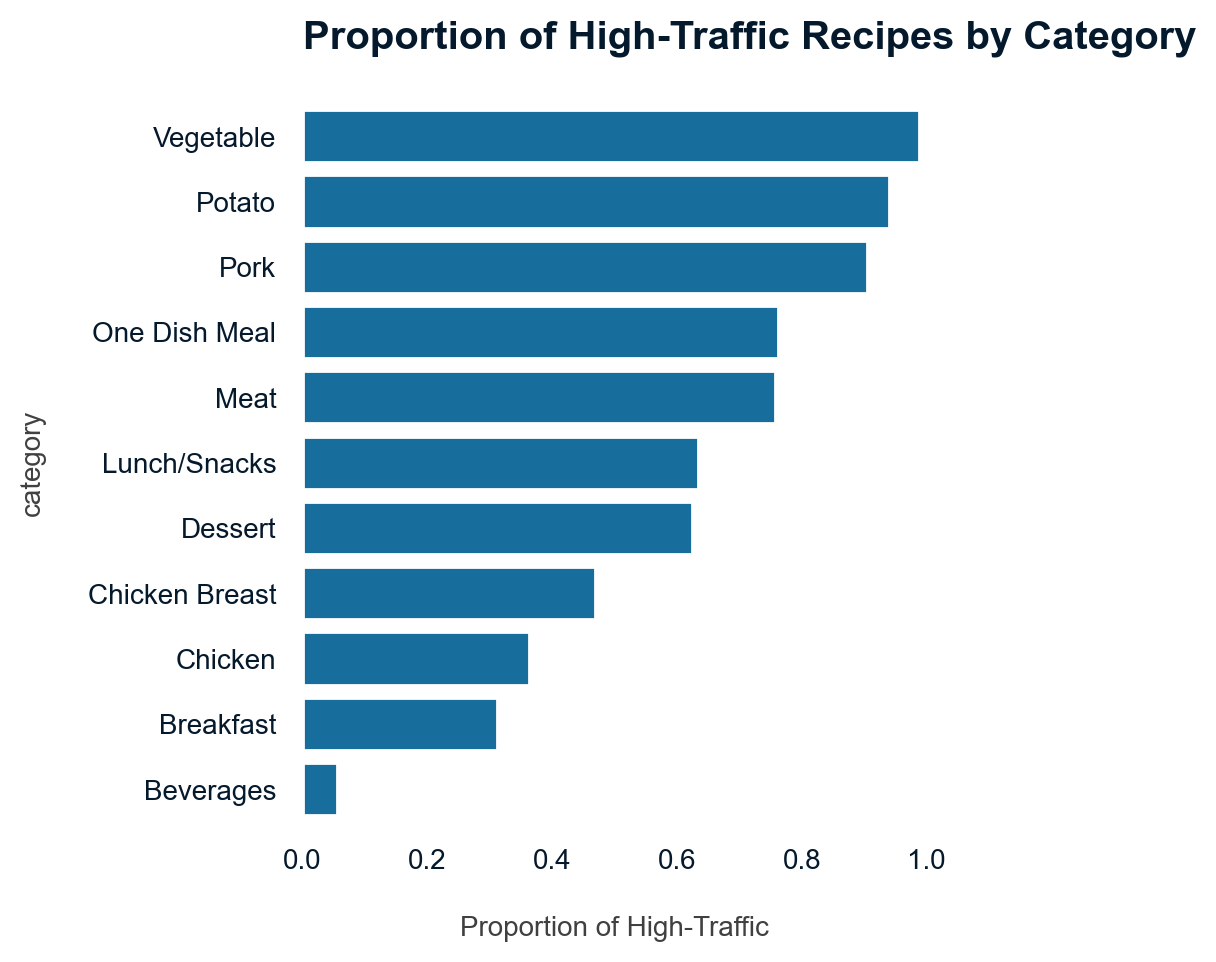

In [92]:
# Calculate proportions
category_proportions = df_clean_data.groupby('category')['high_traffic'].mean().sort_values(ascending=False)

sns.set_theme(style="white")
sns.set_palette('colorblind')
plt.style.use('my_style.mplstyle')

# Plot
plt.figure(figsize=(5, 5))
sns.barplot(
    x=category_proportions.values,
    y=category_proportions.index,
)
plt.title('Proportion of High-Traffic Recipes by Category')
plt.xlabel('Proportion of High-Traffic')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

#### Engineering features

In [93]:
top_categories = ["Vegetable", "Potato", "Pork", "Meat", "Lunch/Snacks", "One Dish Meal"]  
df_clean_data["is_top_category"] = df_clean_data["category"].isin(top_categories).astype(int)
df_clean_data["optimal_servings"] = df_clean_data["servings"].apply(lambda x: 1 if x == 4 else 0)

df_clean_data["meat_for_one"] = (df_clean_data["category"] == "Meat") & (df_clean_data["servings"] == 1)
df_clean_data["lunch_snacks_for_one"] = (df_clean_data["category"] == "Lunch/Snacks") & (df_clean_data["servings"] == 1)
df_clean_data["one_dish_for_six"] = (df_clean_data["category"] == "One Dish Meal") & (df_clean_data["servings"] == 6)
df_clean_data["chicken_high_protein"] = (df_clean_data["category"] == "Chicken Breast") & (df_clean_data["protein"] >= df_clean_data["protein"].median())
df_clean_data["dessert_high_sugar"] = (df_clean_data["category"] == "Dessert") & (df["sugar"] >= df_clean_data["sugar"].median())
df_clean_data["dessert_high_carbo"] = (df_clean_data["category"] == "Dessert") & (df_clean_data["carbohydrate"] >= df_clean_data["carbohydrate"].median())
df_clean_data["one_dish_high_carbo"] = (df_clean_data["category"] == "One Dish Meal") & (df_clean_data["carbohydrate"] >= df_clean_data["carbohydrate"].median())
df_clean_data["potato_high_carbo"] = (df_clean_data["category"] == "Potato") & (df_clean_data["carbohydrate"] >= df_clean_data["carbohydrate"].median())

In [24]:
df_clean_data.columns

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'servings', 'high_traffic', 'is_top_category', 'optimal_servings',
       'meat_for_one', 'lunch_snacks_for_one', 'one_dish_for_six',
       'chicken_high_protein', 'dessert_high_sugar', 'dessert_high_carbo',
       'one_dish_high_carbo', 'potato_high_carbo'],
      dtype='object')

## Models and predictions
Four **classification** models were evaluated to identify the optimal performer for the task: **Logistic Regression**, a linear method favored for interpretability and efficiency on structured data; **Random Forest**, an ensemble of decision trees robust to non-linear relationships and overfitting; and **XGBoost**, a gradient-boosted tree framework optimized for speed and accuracy in imbalanced scenarios. These models were rigorously tested and compared using precision, recall, and F1-score metrics to select the best-performing algorithm for deployment.

Using only the 10 more important features, determined by the coefficients of the Logistic Regression, the best result was achieved by a combination of the Logistic Regression and the Random Forest models, by an ensemble technique called "voting". The performance results of this ensambled model were as high as 81% precision, 75% recall, and 75% accuracy in classifying popular recipes.

### Preparing X's and y's
Spliting train, validation, and test sets, for features and the target.

In [25]:
X = df_clean_data.drop(columns=['recipe','high_traffic'])
y = df_clean_data['high_traffic']

X_train_, X_test, y_train_, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_, y_train_, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["calories", "carbohydrate", "sugar", "protein", "servings"]),
        ("cat", OneHotEncoder(), ["category"])
        ,("interact", "passthrough", ["is_top_category"
                                      ,"meat_for_one"
                                      ,"lunch_snacks_for_one"
                                      ,"one_dish_for_six"
                                      ,"chicken_high_protein"
                                      ,"dessert_high_sugar"
                                      ,"dessert_high_carbo"
                                      ,"one_dish_high_carbo"
                                      ,"potato_high_carbo"
                                     ])
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

### The base model
A simple logistic regression.

In [26]:
clf = LogisticRegression(class_weight='balanced', max_iter=1000, C=5)
clf.fit(X_train_processed, y_train)

y_pred = clf.predict(X_val_processed)

y_pred_proba = clf.predict_proba(X_val_processed)[:, 1]  # P(class=1)
y_pred_class = clf.predict(X_val_processed)  # Binary 0/1

# Improving classification threshold (Likely < 0.5 to boost recall)
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
#optimal_threshold = thresholds[np.argmax(f1_scores)]

optimal_idx = np.nanargmax(f1_scores)  # Ignores NaN values
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Optimal F1-Score: {optimal_f1:.2f}")

y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

Optimal Threshold: 0.16
Optimal F1-Score: 0.79


Accuracy: 0.6944444444444444
Precision: 0.6589147286821705
Recall: 1.0
ROC AUC: 0.7990029910269192


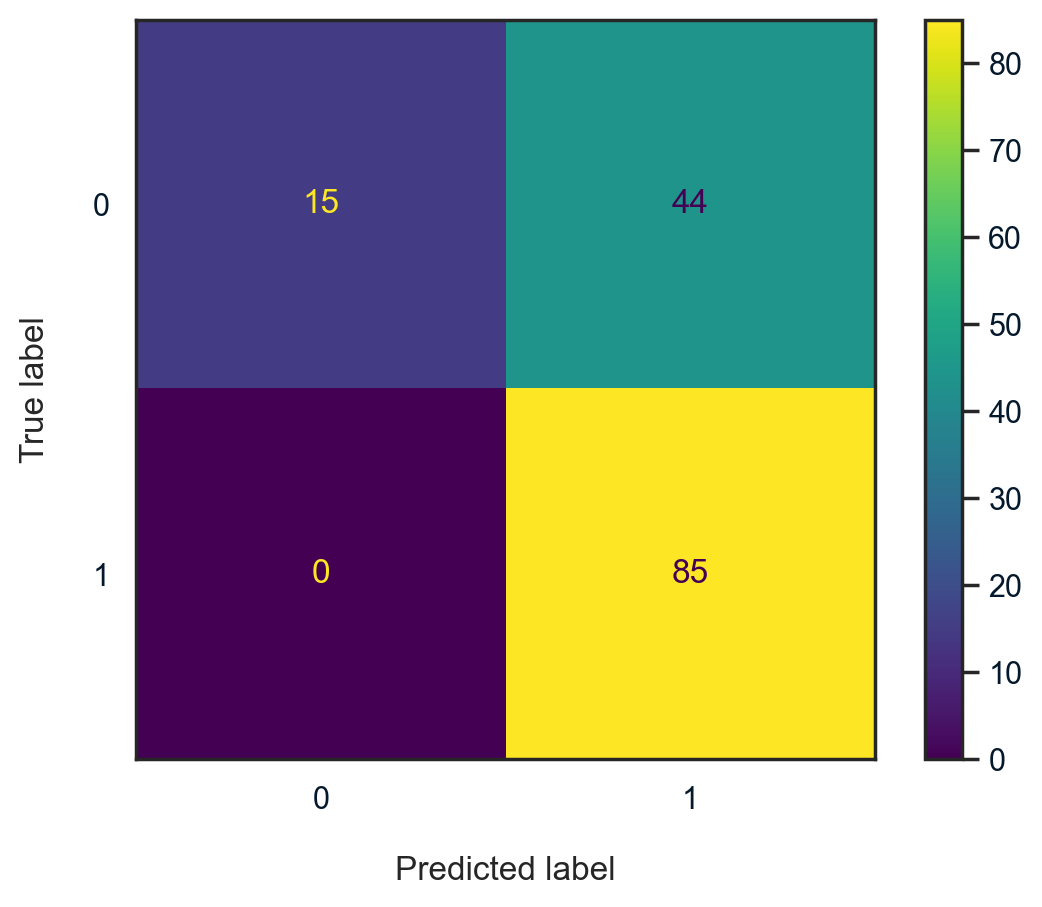

              precision    recall  f1-score   support

           0       1.00      0.25      0.41        59
           1       0.66      1.00      0.79        85

    accuracy                           0.69       144
   macro avg       0.83      0.63      0.60       144
weighted avg       0.80      0.69      0.64       144



In [27]:
# For binary predictions (0/1)
print("Accuracy:", accuracy_score(y_val, y_pred_optimized))
print("Precision:", precision_score(y_val, y_pred_optimized))
print("Recall:", recall_score(y_val, y_pred_optimized))
print("ROC AUC:", roc_auc_score(y_val, y_pred_proba))  # Uses probabilities

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_optimized)
plt.show()

print(classification_report(y_val, y_pred_optimized))

#### Importances

In [28]:
importances = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'coef': clf.coef_[0]  # LogisticRegression coefficients
}).sort_values('coef', key=abs, ascending=False)

print(importances)

                           feature      coef
15         cat__category_Vegetable  3.034108
18  interact__lunch_snacks_for_one  2.469978
17          interact__meat_for_one  2.351178
16       interact__is_top_category  2.253750
5          cat__category_Beverages -2.013498
21    interact__dessert_high_sugar  1.750310
24     interact__potato_high_carbo  1.631312
10      cat__category_Lunch/Snacks -0.939688
9            cat__category_Dessert -0.821857
22    interact__dessert_high_carbo  0.699817
8     cat__category_Chicken Breast  0.670971
19      interact__one_dish_for_six  0.590189
13              cat__category_Pork  0.549269
11              cat__category_Meat -0.547376
20  interact__chicken_high_protein  0.476640
6          cat__category_Breakfast -0.358776
23   interact__one_dish_high_carbo -0.287684
7            cat__category_Chicken  0.265931
14            cat__category_Potato  0.114689
0                    num__calories -0.071886
4                    num__servings  0.049318
12     cat

### Comparison models
Logistic regression with cross validation training, Random Forest, and an XGBoost classifier.

#### Logistic Regression

In [29]:
# Define hyperparameter grid
grid = {
    "C": np.logspace(-3, 3, 7),  # C: Inverse of regularization strength, it's a set of values from 0.001 to 1000 (7 steps in logarithmic scale)
    "penalty": ["l1", "l2", "elasticnet", None],  # Regularization penalty to be used (L1, L2, ElasticNet, or None)
    "multi_class": ["auto", "ovr", "multinomial"]  # Strategy for handling multiple classes (Auto, One-vs-Rest, or Multinomial)
}

# Create a Logistic Regression model
clf = LogisticRegression(class_weight='balanced')

# Perform Grid Search Cross Validation with 10 folds
clf_cv = GridSearchCV(clf, grid, cv=10)

# Fit the model with training data
clf_cv.fit(X_train_processed, y_train)

# Print the best hyperparameters found
print("Tuned hyperparameters:", clf_cv.best_params_)

Tuned hyperparameters: {'C': 0.1, 'multi_class': 'auto', 'penalty': 'l2'}


In [30]:
y_pred = clf_cv.predict(X_val_processed)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(f"Precision: {precision_score(y_val, y_pred):.2f}")
print(f"Recall: {recall_score(y_val, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_val, y_pred):.2f}")

Accuracy: 0.72
Precision: 0.76
Recall: 0.76
F1-Score: 0.76


Optimal Threshold: 0.25
Optimal F1-Score: 0.80
Accuracy: 0.7222222222222222
Precision: 0.6890756302521008
Recall: 0.9647058823529412
ROC AUC: 0.8013958125623131


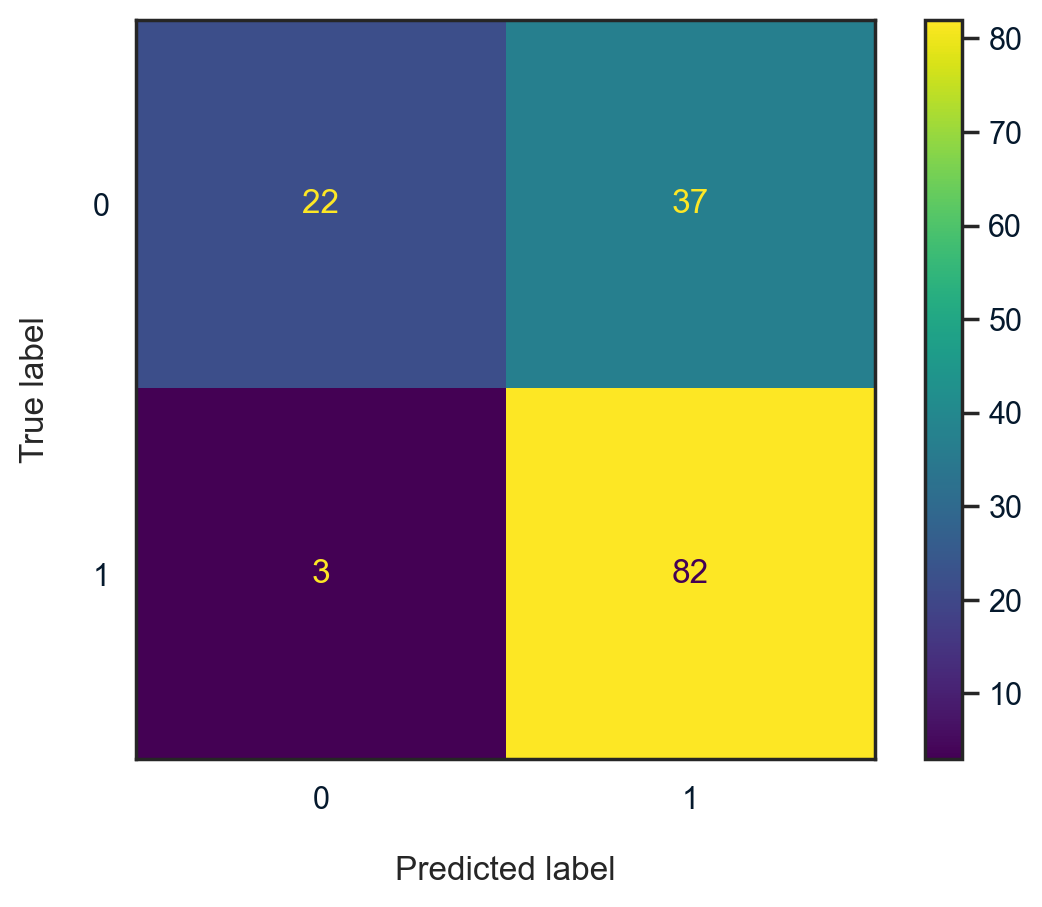

              precision    recall  f1-score   support

           0       0.88      0.37      0.52        59
           1       0.69      0.96      0.80        85

    accuracy                           0.72       144
   macro avg       0.78      0.67      0.66       144
weighted avg       0.77      0.72      0.69       144



In [31]:
y_pred = clf_cv.predict(X_val_processed)

y_pred_proba = clf_cv.predict_proba(X_val_processed)[:, 1]  # P(class=1)
y_pred_class = clf_cv.predict(X_val_processed)  # Binary 0/1

# Improving classification threshold (Likely < 0.5 to boost recall)
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
#optimal_threshold = thresholds[np.argmax(f1_scores)]

optimal_idx = np.nanargmax(f1_scores)  # Ignores NaN values
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Optimal F1-Score: {optimal_f1:.2f}")

y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

# For binary predictions (0/1)
print("Accuracy:", accuracy_score(y_val, y_pred_optimized))
print("Precision:", precision_score(y_val, y_pred_optimized))
print("Recall:", recall_score(y_val, y_pred_optimized))
print("ROC AUC:", roc_auc_score(y_val, y_pred_proba))  # Uses probabilities

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_optimized)
plt.show()

print(classification_report(y_val, y_pred_optimized))

In [32]:
# Define grid of hyperparameters
grid2 = {
    'C': [0.05, 0.1, 0.5, 1],
    'penalty': ["l1", "l2", "elasticnet", None],
    'multi_class': ["auto", "ovr", "multinomial"],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# Test spaces and fit the model
clf_cv2 = LogisticRegression(random_state=42)
clf_cv2 = GridSearchCV(clf, grid2, cv=StratifiedKFold(n_splits=10), scoring='precision', verbose=1)
clf_cv2.fit(X_train_processed, y_train)


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.05, 0.1, 0.5, 1],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg']},
             scoring='precision', verbose=1)

In [33]:
y_pred = clf_cv2.predict(X_val_processed)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(f"Precision: {precision_score(y_val, y_pred):.2f}")
print(f"Recall: {recall_score(y_val, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_val, y_pred):.2f}")

Accuracy: 0.71
Precision: 0.77
Recall: 0.72
F1-Score: 0.74


In [34]:
# Results
print(f'Best Score: {clf_cv2.best_score_}')
print(f'Best Hyperparameters: {clf_cv2.best_params_}')
print(f'Std deviation of CV scores for the best hyperparameters: {clf_cv2.cv_results_["std_test_score"][clf_cv2.best_index_]}')

y_pred = clf_cv2.predict(X_val_processed)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(f"Precision: {precision_score(y_val, y_pred):.2f}")
print(f"Recall: {recall_score(y_val, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_val, y_pred):.2f}")

y_proba = clf_cv2.predict_proba(X_val_processed)[:, 1]  # Probabilities for class 1

# Find threshold for 85% precision
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba)
target_idx = np.argmax(precisions >= 0.75)
target_threshold = thresholds[target_idx]

# Apply threshold
y_pred_high_precision = (y_proba >= target_threshold).astype(int)
print(f"Precision at threshold={target_threshold:.2f}: {precision_score(y_val, y_pred_high_precision):.2f}")

Best Score: 0.8563857158453022
Best Hyperparameters: {'C': 0.05, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
Std deviation of CV scores for the best hyperparameters: 0.05452755308618938
Accuracy: 0.71
Precision: 0.77
Recall: 0.72
F1-Score: 0.74
Precision at threshold=0.72: 0.77


In [35]:
clf_tuned = LogisticRegression(C=0.05, multi_class='auto', penalty='l1', solver='liblinear')
clf_tuned.fit(X_train_processed, y_train)

LogisticRegression(C=0.05, penalty='l1', solver='liblinear')

#### Random Forest

In [36]:
# Train RF with sample_weight (approximation)
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=15,
    min_samples_split=15,
    random_state=42
)

rf.fit(X_train_processed, y_train)

# Get probabilities for class 1
y_proba_rf = rf.predict_proba(X_val_processed)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_rf)

# Find the FIRST threshold where precision >= 80%
target_idx = next(i for i, p in enumerate(precisions) if p >= 0.80)
target_threshold = thresholds[target_idx]

# Apply threshold
y_pred_high_precision = (y_proba_rf >= target_threshold).astype(int)
print(classification_report(y_val, y_pred_high_precision))

print(f"Max precision: {precisions.max():.2f}")

              precision    recall  f1-score   support

           0       0.65      0.75      0.69        59
           1       0.80      0.72      0.76        85

    accuracy                           0.73       144
   macro avg       0.72      0.73      0.73       144
weighted avg       0.74      0.73      0.73       144

Max precision: 1.00


In [37]:
# Get top-10 features after initial training
top_features = importances.head(10)['feature'].tolist()

# Prune data to top features
X_train_pruned = X_train_processed[:, [i for i, f in enumerate(preprocessor.get_feature_names_out()) if f in top_features]]
X_val_pruned = X_val_processed[:, [i for i, f in enumerate(preprocessor.get_feature_names_out()) if f in top_features]]

# Re-train on pruned data
rf_pruned = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_pruned.fit(X_train_pruned, y_train)

# Get probabilities for class 1
y_proba_rf = rf_pruned.predict_proba(X_val_pruned)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_rf)

# Find the FIRST threshold where precision >= 80%
target_idx = next(i for i, p in enumerate(precisions) if p >= 0.8)
target_threshold = thresholds[target_idx]

# Apply threshold
y_pred_high_precision = (y_proba_rf >= target_threshold).astype(int)
print(classification_report(y_val, y_pred_high_precision))

print(f"Max precision: {precisions.max():.2f}")

              precision    recall  f1-score   support

           0       0.66      0.76      0.71        59
           1       0.82      0.73      0.77        85

    accuracy                           0.74       144
   macro avg       0.74      0.75      0.74       144
weighted avg       0.75      0.74      0.74       144

Max precision: 1.00


In [38]:
importances_rf = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print(importances_rf)

                           feature  importance
16       interact__is_top_category    0.223364
3                     num__protein    0.129952
1                num__carbohydrate    0.087896
2                       num__sugar    0.085814
5          cat__category_Beverages    0.085785
0                    num__calories    0.084027
15         cat__category_Vegetable    0.063385
6          cat__category_Breakfast    0.046077
4                    num__servings    0.028215
14            cat__category_Potato    0.024353
13              cat__category_Pork    0.021152
7            cat__category_Chicken    0.013611
24     interact__potato_high_carbo    0.013362
21    interact__dessert_high_sugar    0.013121
8     cat__category_Chicken Breast    0.012622
22    interact__dessert_high_carbo    0.010848
9            cat__category_Dessert    0.010568
10      cat__category_Lunch/Snacks    0.010507
20  interact__chicken_high_protein    0.008149
11              cat__category_Meat    0.007766
12     cat__c

In [39]:
from sklearn.model_selection import GridSearchCV  

params = {  
    'max_depth': [15, 25, 50],  
    'min_samples_split': [10, 20, 50],  
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]  
}  
rf_pruned_cv = GridSearchCV(RandomForestClassifier(), params, scoring='recall')  
rf_pruned_cv.fit(X_train_pruned, y_train)

# Get probabilities for class 1
y_proba_rf = rf_pruned_cv.predict_proba(X_val_pruned)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_rf)

# Find the FIRST threshold where precision >= 80%
target_idx = next(i for i, p in enumerate(precisions) if p >= 0.8)
target_threshold = thresholds[target_idx]

# Apply threshold
y_pred_high_precision = (y_proba_rf >= target_threshold).astype(int)
print(classification_report(y_val, y_pred_high_precision))

print(f"Max precision: {precisions.max():.2f}")

              precision    recall  f1-score   support

           0       0.66      0.76      0.71        59
           1       0.82      0.73      0.77        85

    accuracy                           0.74       144
   macro avg       0.74      0.75      0.74       144
weighted avg       0.75      0.74      0.74       144

Max precision: 1.00


#### XGBoost

In [40]:
# Calculate class imbalance ratio
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Initialize and train
xgb = XGBClassifier(
    scale_pos_weight=2,       # Handles class imbalance
    max_depth=15,             # Simpler trees to prevent overfitting
    n_estimators=200,
    eval_metric='logloss',    # Optimize for log loss (good for binary)
    random_state=42
)
xgb.fit(X_train_processed, y_train)

# Get probabilities
y_proba_xgb = xgb.predict_proba(X_val_processed)[:, 1]

# Find threshold for 80% precision
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_xgb)

if precisions.max() <= 0.8:
    print(f"Max precision achievable: {precisions.max():.2f}")
    target_threshold = thresholds[precisions.argmax()]
else:
    target_idx = next(i for i, p in enumerate(precisions) if p >= 0.8)
    target_threshold = thresholds[target_idx]

# Apply threshold
y_pred_xgb = (y_proba_xgb >= target_threshold).astype(int)
print(classification_report(y_val, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.57      0.80      0.66        59
           1       0.80      0.58      0.67        85

    accuracy                           0.67       144
   macro avg       0.68      0.69      0.67       144
weighted avg       0.71      0.67      0.67       144



In [41]:
# Calculate class imbalance ratio
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Initialize and train
xgb_pruned = XGBClassifier(
    scale_pos_weight=3,      # Handles class imbalance
    max_depth=3,            # Simpler trees to prevent overfitting
    n_estimators=200,
    eval_metric='logloss',   # Optimize for log loss (good for binary)
    random_state=42
)
xgb_pruned.fit(X_train_pruned, y_train)

# Get probabilities
y_proba_xgb = xgb_pruned.predict_proba(X_val_pruned)[:, 1]

# Find threshold for 80% precision
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_xgb)

if precisions.max() <= 0.8:
    print(f"Max precision achievable: {precisions.max():.2f}")
    target_threshold = thresholds[precisions.argmax()]
else:
    target_idx = next(i for i, p in enumerate(precisions) if p >= 0.8)
    target_threshold = thresholds[target_idx]

# Apply threshold
y_pred_xgb = (y_proba_xgb >= target_threshold).astype(int)
print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71        59
           1       0.82      0.73      0.77        85

    accuracy                           0.74       144
   macro avg       0.74      0.75      0.74       144
weighted avg       0.75      0.74      0.74       144



### Final evaluation
In spyte of evaluating the performace on train and validation sets, when trained on the full training set — X_train and X_val —, the ensembled model performed with 81% precision and 75% recall on predicting popular recipes on unseen data — X_test.

In [42]:
# Evaluate on training data
y_pred_train = rf_pruned.predict(X_train_pruned)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)

# Evaluate on validation data
y_pred_val = rf_pruned.predict(X_val_pruned)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(f"Validation Precision: {val_precision:.2f}")

Training Accuracy: 0.77
Validation Accuracy: 0.72
Training Precision: 0.84
Validation Precision: 0.76


In [43]:
# Combine X_train and X_val (already done in X_train_, y_train_)
# Preprocess the full training data
X_train_processed_final = preprocessor.fit_transform(X_train_)
# Transform the test set with the preprocessor fitted on X_train_
X_test_processed = preprocessor.transform(X_test)

In [50]:
# Use the selected model
rf_pruned.fit(X_train_processed, y_train)

# Evaluate on the test set
y_test_pred = rf_pruned.predict(X_test_processed)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.66      0.58      0.61        73
           1       0.73      0.79      0.76       106

    accuracy                           0.70       179
   macro avg       0.69      0.68      0.69       179
weighted avg       0.70      0.70      0.70       179



In [47]:
# Use the selected model
clf_tuned.fit(X_train_processed, y_train)

# Evaluate on the test set
y_test_pred = clf_tuned.predict(X_test_processed)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        73
           1       0.81      0.75      0.78       106

    accuracy                           0.75       179
   macro avg       0.74      0.75      0.74       179
weighted avg       0.76      0.75      0.75       179



### Selected model
An voting ensemble classifier performed better than previous tested models. A balanced approach between interpretability (Logistic Regression) and performance (Random Forest). Hyperparameter tuning and threshold optimization align with the 80% precision goal.

In [53]:
from sklearn.ensemble import VotingClassifier  

ensemble = VotingClassifier(
    estimators=[("logreg", clf_tuned), ("rf", rf_pruned)],
    voting="hard"  # Uses probabilities
    , weights=[2, 1]
)
ensemble.fit(X_train_processed_final, y_train_)
y_test_pred = ensemble.predict(X_test_processed)
print(classification_report(y_test, y_test_pred))  

              precision    recall  f1-score   support

           0       0.67      0.75      0.71        73
           1       0.81      0.75      0.78       106

    accuracy                           0.75       179
   macro avg       0.74      0.75      0.74       179
weighted avg       0.76      0.75      0.75       179



## The metric
The marketing team can rely on monitoring the **precision** of the model. **It should stay higher than 80%**, as the model performed well in unseen data.

Why Not Accuracy?
- Imbalanced Data: If most recipes are not high-traffic (common in many real-world datasets), a model can achieve high accuracy by simply predicting "not popular" most of the time. This is misleading and useless for marketing.
- Actionability: Marketing campaigns rely on targeted actions (promoting specific recipes). Precision ensures those actions are trustworthy.

## Further recommendations

1. Deploy the Ensemble Model using a **metric to monitor**:
- The voting ensemble (logistic regression + random forest) achieves 81% precision on unseen data, meeting the product team’s requirement to predict popular recipes 80% of the time—**the metric is "precision = 0.8"**. Use this model to select homepage recipes.
- Develop an admin prediction tool using Python + joblib (to load the model/preprocessor), Streamlit (for a GUI), or Flask/Django (for API integration), outputting “POPULAR”/“NOT POPULAR” with probability (e.g., 82%) based on inputs: nutritional values, category, servings.

2. Monitor Model Performance:
- Define a weekly tracking metric: Percentage of model-recommended recipes that result in "High" traffic.
- Initial baseline: 81% precision (from test data). If performance drops below 75%, retrain the model with new data.

3. Hybrid Human-Model Decision Making:
- Allow the product manager to override model predictions for edge cases (e.g., recipes where the model’s confidence is between 60-80%). This balances automation with human expertise.

4. Collect Additional Data:
- Address gaps in the dataset:
- Track missing high_traffic labels retroactively (almost was 40% missing).
- Gather user feedback (e.g., ratings, cooking time) to enrich features.

5. Conduct A/B Testing:
- Run a 2-week experiment comparing traffic from model-selected recipes vs. the current manual approach. Measure:
- % increase in site traffic.
- Subscription conversions from homepage visits.

6. Improve Interpretability:
- Provide the product team with a dashboard highlighting key drivers of recipe popularity (e.g., "Vegetable recipes with 4 servings are 2x more likely to drive traffic").

7. Address Class Imbalance:
- While class weights were used, continue monitoring the distribution of high_traffic labels. If imbalance worsens, adopt synthetic oversampling (e.g., SMOTE).

8. Explore New Features:
- Test adding cost-per-serving or recipe difficulty (if data becomes available). EDA suggests high-protein chicken recipes perform well—partner with creators to expand this category.

## ✅ 